In [169]:
import ast
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, wasserstein_distance

%matplotlib inline

In [212]:
sns.set_theme(context='notebook', style='ticks', font_scale=1.25)

In [213]:
EXPERIMENT_ID = "run-2023-01-30-12-55-36"

FILE_STIMULI = os.path.join("../", "prompting", "data", "stimuli_v1.csv")
FILE_CODEX_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "codex", "results.csv")
FILE_SIMULATOR_RESULTS = os.path.join("../", "experiments", EXPERIMENT_ID, "webppl", "simulator_results.csv")
FILE_HUMAN_DATA = os.path.join("human_data_full.csv")
FILE_BASELINE_ZEROSHOT = os.path.join("../", "codex-baseline", "codex_baseline_v1_zeroshot_code-davinci-002_results.csv")
FILE_BASELINE_FEWSHOT = os.path.join("../", "codex-baseline", "codex_baseline_v1_fewshot_code-davinci-002_results.csv")

In [214]:
df_stimuli = pd.read_csv(FILE_STIMULI, keep_default_na=False)
df_codex = pd.read_csv(FILE_CODEX_RESULTS, keep_default_na=False)
df_simulator = pd.read_csv(FILE_SIMULATOR_RESULTS, keep_default_na=False)

df_human = pd.read_csv(FILE_HUMAN_DATA, keep_default_na=False)
df_human.index = df_human.index.astype(int)
df_human = df_human.rename(axis="columns", mapper={"response": "likert_human", "run_id": "participant_id"})

df_baseline_zeroshot = pd.read_csv(FILE_BASELINE_ZEROSHOT, keep_default_na=False)
df_baseline_zeroshot["probs"] = df_baseline_zeroshot["probs"].apply(ast.literal_eval)

df_baseline_fewshot = pd.read_csv(FILE_BASELINE_FEWSHOT, keep_default_na=False)
df_baseline_fewshot["probs"] = df_baseline_fewshot["probs"].apply(ast.literal_eval)

In [215]:
df_human_tall = df_human[["task_id", "participant_id", "likert_human"]].copy()
df_human_tall["participant_id"] = [f"human_{pid:03}" for pid in df_human_tall["participant_id"]]
df_human_tall["source"] = "human"
df_human_tall = df_human_tall[["source", "task_id", "participant_id", "likert_human"]].sort_values(["task_id", "participant_id"])
df_human_tall

,source,task_id,participant_id,likert_human
32,human,1,human_003,1
64,human,1,human_005,5
160,human,1,human_012,2
176,human,1,human_013,2
272,human,1,human_020,2
...,...,...,...,...
2191,human,64,human_153,3
2271,human,64,human_158,3
2335,human,64,human_162,2
2383,human,64,human_165,3


In [216]:
N_PSEUDOPARTICIPANTS = 50
data = []

for _, row in df_simulator.iterrows():
    if not row["probs"]:
        raise ValueError(f"WARNING: No results for task_id {task_id}")
    
    probs = ast.literal_eval(row["probs"])
    support = ast.literal_eval(row["support"])
    
    for p, v in zip(probs, support):
        for _ in range(round(N_PSEUDOPARTICIPANTS * p)):
            data.append({
                "task_id": row["task_id"],
                "likert_model": v,
                # "example_answer": row["example_answer"]
            })
            
df_simulator_tall = pd.DataFrame(data)
df_simulator_tall["source"] = "PiLoT (ours)"
df_simulator_tall["participant_id"] = "simulator_000"
df_simulator_tall = df_simulator_tall[["source", "task_id", "participant_id", "likert_model"]].sort_values(["task_id", "participant_id"])
df_simulator_tall

,source,task_id,participant_id,likert_model
0,PiLoT (ours),1,simulator_000,1
1,PiLoT (ours),1,simulator_000,1
2,PiLoT (ours),1,simulator_000,1
3,PiLoT (ours),1,simulator_000,1
4,PiLoT (ours),1,simulator_000,1
...,...,...,...,...
3195,PiLoT (ours),64,simulator_000,4
3196,PiLoT (ours),64,simulator_000,4
3197,PiLoT (ours),64,simulator_000,4
3198,PiLoT (ours),64,simulator_000,4


In [217]:
def transform_probs_to_likert(probs):
    return np.dot(probs, np.array([1, 2, 3, 4, 5, 6, 7]))

df_baseline_zeroshot_tall["likert_model"] = df_baseline_zeroshot["probs"].apply(transform_probs_to_likert)
df_baseline_fewshot_tall["likert_model"] = df_baseline_fewshot["probs"].apply(transform_probs_to_likert)

df_baseline_zeroshot_tall["participant_id"] = "baseline_zeroshot_000"
df_baseline_fewshot_tall["participant_id"] = "baseline_fewshot_000"

df_baseline_zeroshot_tall["source"] = "Baseline (zero-shot)"
df_baseline_fewshot_tall["source"] = "Baseline (few-shot)"

df_baseline_zeroshot_tall = df_baseline_zeroshot_tall[["source", "task_id", "participant_id", "likert_model"]].sort_values(["task_id", "participant_id"])
df_baseline_fewshot_tall = df_baseline_fewshot_tall[["source", "task_id", "participant_id", "likert_model"]].sort_values(["task_id", "participant_id"])

In [218]:
df_baseline_zeroshot_tall

,source,task_id,participant_id,likert_model
0,Baseline (zero-shot),1,baseline_zeroshot_000,3.265482
1,Baseline (zero-shot),2,baseline_zeroshot_000,3.546846
2,Baseline (zero-shot),3,baseline_zeroshot_000,3.260392
3,Baseline (zero-shot),4,baseline_zeroshot_000,3.658129
4,Baseline (zero-shot),5,baseline_zeroshot_000,3.380624
...,...,...,...,...
59,Baseline (zero-shot),60,baseline_zeroshot_000,3.278884
60,Baseline (zero-shot),61,baseline_zeroshot_000,3.868655
61,Baseline (zero-shot),62,baseline_zeroshot_000,3.731972
62,Baseline (zero-shot),63,baseline_zeroshot_000,3.559590


In [219]:
df_baseline_fewshot_tall

,source,task_id,participant_id,likert_model
0,Baseline (few-shot),1,baseline_fewshot_000,3.701409
1,Baseline (few-shot),2,baseline_fewshot_000,3.864697
2,Baseline (few-shot),3,baseline_fewshot_000,3.890453
3,Baseline (few-shot),4,baseline_fewshot_000,4.156618
4,Baseline (few-shot),5,baseline_fewshot_000,3.630740
...,...,...,...,...
59,Baseline (few-shot),60,baseline_fewshot_000,3.011240
60,Baseline (few-shot),61,baseline_fewshot_000,3.917606
61,Baseline (few-shot),62,baseline_fewshot_000,4.225019
62,Baseline (few-shot),63,baseline_fewshot_000,3.861019


## Merge

In [220]:
df_model_tall = pd.concat([df_simulator_tall, df_baseline_zeroshot_tall, df_baseline_fewshot_tall]).reset_index(drop=True).groupby(["task_id", "source"]).mean().reset_index()
df_model_tall

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/1819788326.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_model_tall = pd.concat([df_simulator_tall, df_baseline_zeroshot_tall, df_baseline_fewshot_tall]).reset_index(drop=True).groupby(["task_id", "source"]).mean().reset_index()


,task_id,source,likert_model
0,1,Baseline (few-shot),3.701409
1,1,Baseline (zero-shot),3.265482
2,1,PiLoT (ours),1.920000
3,2,Baseline (few-shot),3.864697
4,2,Baseline (zero-shot),3.546846
...,...,...,...
187,63,Baseline (zero-shot),3.559590
188,63,PiLoT (ours),5.480000
189,64,Baseline (few-shot),3.837640
190,64,Baseline (zero-shot),3.372042


In [230]:
df_comparison_human_model = df_model_tall.join(df_human_tall.groupby("task_id").mean(), on="task_id")
df_comparison_human_model = df_comparison_human_model.rename({"source": "model", "likert_human": "Human rating (Likert)", "likert_model": "Model rating (Likert)"}, axis=1)
df_comparison_human_model = df_comparison_human_model.sort_values("model", ascending=False)
df_comparison_human_model

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_24693/1912532782.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_comparison_human_model = df_model_tall.join(df_human_tall.groupby("task_id").mean(), on="task_id")


,task_id,model,Model rating (Likert),Human rating (Likert)
191,64,PiLoT (ours),2.700000,2.595238
44,15,PiLoT (ours),3.060000,2.625000
161,54,PiLoT (ours),3.120000,5.095238
89,30,PiLoT (ours),5.040000,5.675000
86,29,PiLoT (ours),6.700000,6.789474
...,...,...,...,...
84,29,Baseline (few-shot),4.388279,6.789474
81,28,Baseline (few-shot),3.524532,1.789474
78,27,Baseline (few-shot),4.464339,2.825000
75,26,Baseline (few-shot),4.052853,4.880952


/opt/anaconda3/envs/physlang/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/physlang/lib/python3.9/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


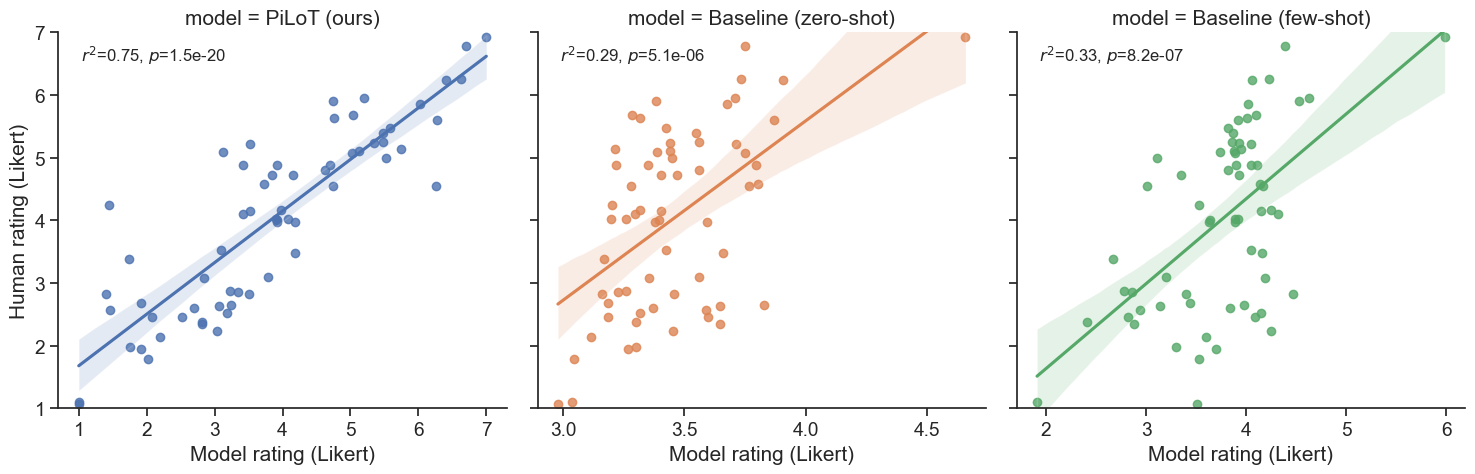

In [231]:
g = sns.lmplot(data=df_comparison_human_model, x="Model rating (Likert)", y="Human rating (Likert)", col="model", sharex=False, sharey=True, hue="model")
g.set(ylim=(1, 7))

def annotate(data, **kws):
    r, p = pearsonr(data['Model rating (Likert)'].tolist(), data['Human rating (Likert)'].tolist())
    ax = plt.gca()
    ax.text(.05, 0.925, r'$r^2$={:.2f}, $p$={:.2g}'.format(r ** 2, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")

In [210]:
df_simulator_mean = df_simulator.groupby("task_id").mean("likert")
df_human_mean = df_human.groupby("task_id").mean("likert_human")
df_comparison = df_simulator_mean.join(df_human_mean[["likert_human"]], how="inner")
df_comparison.to_csv("comparison_simulator_human.csv")

## EXPORT

In [211]:
pd.concat([df_human_tall, df_simulator_tall]).reset_index(drop=True).to_csv("comparison_human_simulator.csv")

In [52]:
rho, pval = pearsonr(df_comparison["likert_simulator"].tolist(), df_comparison["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

NameError: name 'df_comparison' is not defined

In [53]:
sns.regplot(data=df_comparison, x="likert_simulator", y="likert_human")
plt.xlabel("Neurosymbolic LoT physics simulator (Likert)")
plt.ylabel("Human participants (Likert)")
plt.title(fr"Model vs. human ratings ($r^2={(rho ** 2):.04f}$)")
plt.savefig(f"physlang_model_human_results.png", dpi=300)

NameError: name 'df_comparison' is not defined

In [54]:
sns.jointplot(data=df_comparison, x="likert_simulator", y="likert_human", kind="reg")

NameError: name 'df_comparison' is not defined

In [ ]:
def transform_probs_to_likert(probs):
    return np.dot(probs, np.array([1, 2, 3, 4, 5, 6, 7]))

df_baseline_zeroshot_tall["likert_baseline_zeroshot"] = df_baseline_zeroshot_tall["probs"].apply(transform_probs_to_likert)
df_baseline_fewshot_tall["likert_baseline_fewshot"] = df_baseline_fewshot_tall["probs"].apply(transform_probs_to_likert)

In [ ]:
df_baseline_zeroshot_tall

In [ ]:
df_baseline_zeroshot_tall["likert_baseline_zeroshot"].hist()

In [ ]:
df_baseline_fewshot_tall["likert_baseline_fewshot"].hist()

In [ ]:
df_comparison_baseline_zeroshot = df_baseline_zeroshot_tall.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison_baseline_zeroshot, x="likert_baseline_zeroshot", y="likert_human")

In [ ]:
rho, pval = pearsonr(df_comparison_baseline_zeroshot["likert_baseline_zeroshot"].tolist(), df_comparison_baseline_zeroshot["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

In [ ]:
df_comparison_baseline_fewshot = df_baseline_fewshot_tall.join(df_human_mean[["likert_human"]], how="inner")
sns.regplot(data=df_comparison_baseline_fewshot, x="likert_baseline_fewshot", y="likert_human")

In [ ]:
rho, pval = pearsonr(df_comparison_baseline_fewshot["likert_baseline_fewshot"].tolist(), df_comparison_baseline_fewshot["likert_human"].tolist())
print(rho, pval)
print(rho ** 2)

In [ ]:
sns.regplot(data=df_comparison, x="likert_simulator", y="likert_human")
sns.regplot(data=df_comparison_baseline_zeroshot, x="likert_baseline_zeroshot", y="likert_human")
sns.regplot(data=df_comparison_baseline_fewshot, x="likert_baseline_fewshot", y="likert_human")

In [ ]:
def tall_to_wide(df, likert_col: str = "likert"):

    data = []
    for task_id, df_group in df.groupby("task_id"):

        value_counts = {likert_value: 0.0 for likert_value in [1, 2, 3, 4, 5, 6, 7]}
        for likert_value, weight in df_group[likert_col].value_counts(normalize=True).sort_index().items():
            value_counts[likert_value] = weight
        likert_weights = list(value_counts.values())

        data.append({
            "task_id": task_id,
            "likert_weights": likert_weights,
        })

    df_wide = pd.DataFrame(data)
    assert np.allclose(df_wide["likert_weights"].apply(sum), 1.0)
    return df_wide

In [ ]:
df_human_wide = tall_to_wide(df_human, likert_col="likert_human")
df_human_wide["source"] = "human"
df_human_wide

In [ ]:
df_simulator_wide = tall_to_wide(df_simulator, likert_col="likert_simulator")
df_simulator_wide["source"] = "simulator"
df_simulator_wide

In [ ]:
df_baseline_zeroshot_tall_wide = df_baseline_zeroshot_tall[["probs"]].rename({"probs": "likert_weights"}, axis="columns").reset_index()
assert np.allclose(df_baseline_zeroshot_tall_wide["likert_weights"].apply(sum), 1.0)
df_baseline_zeroshot_tall_wide["source"] = "baseline_zeroshot"
df_baseline_zeroshot_tall_wide

In [ ]:
df_baseline_fewshot_tall_wide = df_baseline_fewshot_tall[["probs"]].rename({"probs": "likert_weights"}, axis="columns").reset_index()
assert np.allclose(df_baseline_fewshot_tall_wide["likert_weights"].apply(sum), 1.0)
df_baseline_fewshot_tall_wide["source"] = "baseline_fewshot"
df_baseline_fewshot_tall_wide

In [ ]:
df_comparison_wide = pd.concat([df_human_wide, df_simulator_wide, df_baseline_zeroshot_tall_wide, df_baseline_fewshot_tall_wide]).sort_values("task_id").reset_index(drop=True)
df_comparison_wide

In [ ]:
data = []

for task_id, df_group in df_comparison_wide.groupby("task_id"):
    
    likert = [1, 2, 3, 4, 5, 6, 7]
    
    likert_weights_human = df_group[df_group["source"] == "human"]["likert_weights"].item()
    likert_weights_simulator = df_group[df_group["source"] == "simulator"]["likert_weights"].item()
    likert_weights_baseline_zeroshot = df_group[df_group["source"] == "baseline_zeroshot"]["likert_weights"].item()
    likert_weights_baseline_fewshot = df_group[df_group["source"] == "baseline_fewshot"]["likert_weights"].item()
    
    wd_human_simulator = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_simulator)
    wd_human_baseline_zeroshot = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_baseline_zeroshot)
    wd_human_baseline_fewshot = wasserstein_distance(likert, likert, likert_weights_human, likert_weights_baseline_fewshot)
    
    data.append(
        {
            "task_id": task_id,
            "PhysLoT": wd_human_simulator,
            "Baseline (zero-shot)": wd_human_baseline_zeroshot,
            "Baseline (few-shot)": wd_human_baseline_fewshot,
        }
    )
    
df_wd = pd.DataFrame(data).set_index("task_id")

In [ ]:
sns.histplot(data=df_wd, stat="count", binwidth=0.25, kde=True)
plt.xlabel("Wasserstein distance")
plt.savefig("wasserstein_comparison.png", dpi=300)

In [ ]:
sns.kdeplot(data=df_wd)

In [ ]:
df_human_tall = df_human.drop(["run_id", "complexity", "group"], axis="columns").reset_index()
df_human_tall = df_human_tall.rename({"likert_human": "likert"}, axis="columns")
df_human_tall["source"] = "human"
df_human_tall

In [ ]:
df_simulator_tall = df_simulator.drop("example_answer", axis="columns").reset_index(drop=True)
df_simulator_tall = df_simulator_tall.rename({"likert_simulator": "likert"}, axis="columns")
df_simulator_tall["source"] = "simulator"
df_simulator_tall

In [ ]:
df_baseline_zeroshot_tall_tall = df_baseline_zeroshot_tall[["likert_baseline_zeroshot"]].reset_index()
df_baseline_zeroshot_tall_tall = df_baseline_zeroshot_tall_tall.rename({"likert_baseline_zeroshot": "likert"}, axis="columns")
df_baseline_zeroshot_tall_tall["source"] = "baseline_zeroshot"
df_baseline_zeroshot_tall_tall

In [ ]:
df_comparison_tall = pd.concat([df_human_tall, df_simulator_tall, df_baseline_zeroshot_tall_tall]).sort_values("task_id").reset_index(drop=True)
df_comparison_tall

In [ ]:
data = []

for task_id, df_group in df_comparison_tall.groupby("task_id"):
    
    likert_human = df_group[df_group["source"] == "human"]["likert"].tolist()
    likert_simulator = df_group[df_group["source"] == "simulator"]["likert"].tolist()
    likert_baseline_zeroshot = df_group[df_group["source"] == "baseline_zeroshot"]["likert"].tolist()
    
    wd_human_simulator = wasserstein_distance(likert_human, likert_simulator)
    wd_human_baseline_zeroshot = wasserstein_distance(likert_human, likert_baseline_zeroshot)
    
    data.append(
        {
            "task_id": task_id,
            "wd_human_simulator": wd_human_simulator,
            "wd_human_baseline_zeroshot": wd_human_baseline_zeroshot,
        }
    )
    
df_wd = pd.DataFrame(data).set_index("task_id")